In [2]:
import numpy as np
import tqdm
from multiprocessing import Pool
from contextlib import closing
import sys
sys.path.append("../../")

from phenixml.fragments.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.models.nn_fragments import FragmentKNN
from phenixml.visualization.fragment_display import FragmentDisplay
from phenixml.visualization.plotting import plot_geom_eval
display = FragmentDisplay()


from phenixml.utils.mp_utils import pool_with_progress
from phenixml.utils.torch_utils import to_np
import matplotlib.pyplot as plt

In [3]:
# Load molecule containers
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:32<00:00, 494.29it/s]


In [4]:
# Fragment the molecules
fragmenter = BondFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [00:22<00:00, 733.13it/s]


In [5]:
# Featurize the fragments
featurizer = MorganFeaturizer()
features = featurizer(fragments,nproc=32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396400/396400 [06:13<00:00, 1061.10it/s]


In [6]:
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396400/396400 [05:31<00:00, 1194.27it/s]


In [7]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [8]:
%%time
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train,metric="rogerstanimoto")

CPU times: user 56min 2s, sys: 2min 33s, total: 58min 35s
Wall time: 3min 34s


In [9]:
# choose a single query to illustrate kNN search
query_idx = 101
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

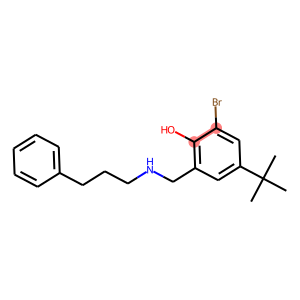

In [10]:
display(query_frag,hideHs=True,size=(300,300))

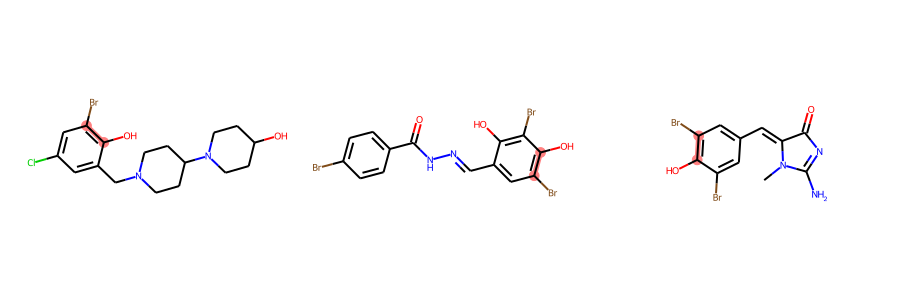

In [11]:
display(nbrs,nmax=3)

In [12]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [13]:
nbr_mean_label = nbr_labels.mean(axis=1)

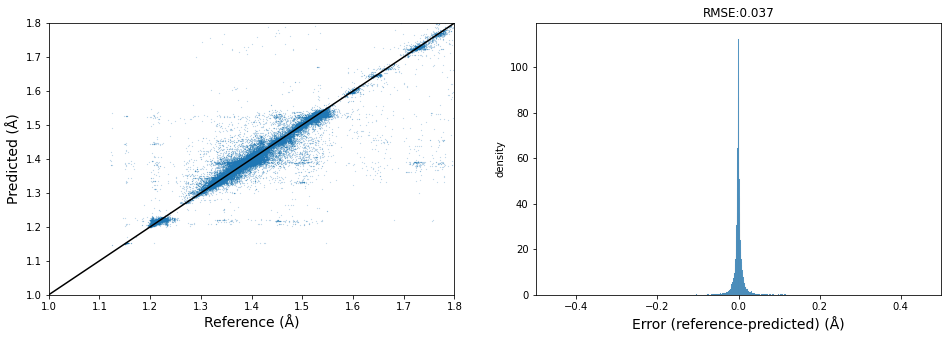

In [14]:
plot_geom_eval(labels_test,nbr_mean_label,mode="bond")

In [15]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15611
Mols better than cutoff: 14927
Mols worse than cutoff: 684


## MLP Regression

In [10]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [11]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=1)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [12]:
# set up tensors
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

In [13]:
def make_batches(lst, n=100000):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [14]:
feature_batches = make_batches(feat_train_t)
label_batches = make_batches(labels_train_t)
batches = list(zip(feature_batches,label_batches))

In [15]:
# train
epoch_losses = []
n_epoch=2000
gpuid = 0

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for feat,label in batches:
    if gpuid is not None:
      feat = feat.to("cuda:"+str(gpuid))
      label = label.to("cuda:"+str(gpuid))
    pred = model(feat)[:,0]
    loss = metric(pred,label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())
  epoch_losses.append(np.mean(batch_losses))
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:31<00:00,  3.17it/s]


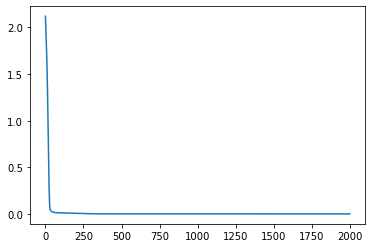

In [16]:
plt.plot(epoch_losses)

In [30]:
if gpuid is not None:
  model = model.to("cpu")
test_pred = model(feat_test_t)[:,0]

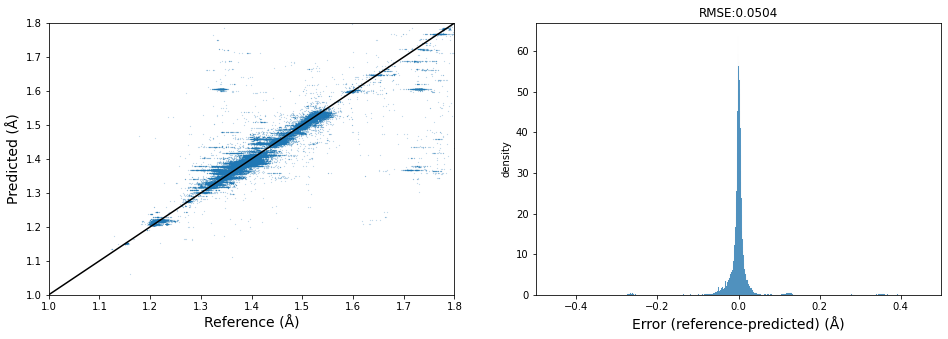

In [19]:
plot_geom_eval(labels_test,to_np(test_pred),mode="bond")

In [32]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = labels_test
labels_test_pred = to_np(test_pred)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 0.1
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15621
Mols better than cutoff: 13503
Mols worse than cutoff: 2118
